In [ ]:
'''
THE DIRECTORY NAMES USED TO STORE THE DATA EXPLAIN THE STRATEGY TO CREATE THE GRAPH:

PSS is the number of PAST SAME SPEAKER considered for each node (e.g. 3PSS means 3 pasts same speaker)
PDS is the number of PAST DIFFERENT SPEAKER considered for each node (e.g. 8PDS means 8 pasts different speaker)
Similarly there are FSS and FDS

"timestamp" or "reply_to" explain how the concept of past and future comments for a specific node is defined:
- timestamp: past and future comments (nodes) are identified by timestamp independently on the tree structure of the
  conversation, this means that a non-main-branch comment of the conversation can be linked with comments of the main branch
- reply_to: past and future comments (nodes) are identified by the reply_to field in the dataset, which considers
  the structure of the conversation
- similarity: nodes are linked dending on how similar the text is
'''

In [ ]:
'''
TO DO:
- check the results on a balanced dataset
- check the results when going in the past follows back the tree structure of the conversation (reply_to)
- check for models that apply explainability on GNNs
- is there a different way to represent/preprocess text
- check for results with different features, POS tags, emotions, number of words, number of deltas, distance from last OP utterance etc...
'''

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch-geometric
!pip3 install convokit
!pip install transformers
!pip install sentencepiece

In [ ]:
#!pip install torch-spline-conv

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, CGConv, SplineConv
from torch_geometric.nn import BatchNorm, global_add_pool
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential
from torch_geometric.nn import GCN, GAT, DeepGCNLayer, GENConv
from torch_geometric.utils import degree
from gensim.models import Word2Vec
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
import tensorflow_hub as hub
from convokit import Corpus, download
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import emoji
import networkx as nx
import matplotlib.pyplot as plt
import traceback
import sys
import os
import json
import random
import statistics
import copy
import string

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline
from scipy.special import softmax

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
%matplotlib inline

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
stop_words = set(stopwords.words('english'))

In [ ]:
# Load Universal Sentence Encoder model
universalSentenceEncoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
robertaModel = f"cardiffnlp/twitter-roberta-base-emotion"

tokenizer = AutoTokenizer.from_pretrained(robertaModel)
tfmodel = TFAutoModelForSequenceClassification.from_pretrained(robertaModel)

In [ ]:
# see https://github.com/CornellNLP/ConvoKit/blob/master/datasets/winning-args-corpus/stats.ipynb for pre-processing
corpus = Corpus(filename=download("winning-args-corpus"))

In [ ]:
#cIds = corpus.get_conversation_ids()

In [6]:
## START: HELPERS

def featureMustBeRecomputed(cDf, featureName):
  return featureName not in cDf.columns or alwaysCompute == True

# outputs scores of emotions in this order [anger, joy, optimism, sadness]
# (each score goes from 0 low intensity, to 1 high intensity)
def getEmotionsScores(text):
    em_labels = ['anger', 'joy', 'optimism', 'sadness']

    encoded_input = tokenizer(text, return_tensors='tf')
    output = tfmodel(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores).tolist()

    return scores

def getSpeakersDeltaFromComment(utteranceIndex):
    numOfDeltasStringUnclean = corpus.get_utterance(utteranceIndex).meta['author_flair_text']
    numOfDeltas = 0
    if numOfDeltasStringUnclean != None:
      try:
        # cleans the string from non-digits characters and then converts to int
        numOfDeltas = int(list(filter(str.isdigit, numOfDeltasStringUnclean))[0])
      except:
        return 0

    return numOfDeltas

def getWordsOfSentenceAsList(sentence):
  return list(str(sentence).lower().split())

def getSentenceNumOfWords(sentence):
    if sentence == None:
      return 0

    return len(getWordsOfSentenceAsList(sentence))

def numberOfcommonWordsBetweenTwoListOfWords(s1, s2):
  commonWords = list(set(s1).intersection(s2))
  return len(commonWords)

def getStopwordsInWordsList(s1):
  return [token for token in s1 if token in stop_words]

def getContentWordsInWordsList(s1):
  return [token for token in s1 if token not in stop_words]

def getRightTimeDiff(tdiff,medianTimeDiff):
    if tdiff == 0:
      return medianTimeDiff

    return tdiff

def jaccard_similarity(doc1, doc2):
    if doc1 == '' or doc2 == '':
      return 0.0

    if type(doc1) == list:
      words_doc_1 = set(doc1)
      words_doc_2 = set(doc2)
    else:
      # List the unique words in a document
      words_doc_1 = set(doc1.lower().split())
      words_doc_2 = set(doc2.lower().split())

    # Find the intersection of words between documents
    intersection = words_doc_1.intersection(words_doc_2)

    # Find the union of words between documents
    union = words_doc_1.union(words_doc_2)

    # Jaccard Similarity
    try:
      jaccardSimilarityCoefficient = 0 if len(union) == 0 else float(len(intersection)) / len(union)
    except:
      print('error while calculating Jaccard similarity')
      print('intersection: ' + str(len(intersection)))
      print('union: ' + str(len(union)))
      jaccardSimilarityCoefficient = 0
    return jaccardSimilarityCoefficient

## END: HELPERS OF EDGE ATTRIBUTE FUNCTIONS

#------------------------------------------------------------------------------------------------------------

## START: EDGE ATTRIBUTE FUNCTIONS

# computes the similarity of two sentences, by default uses the jaccard similarity
def text_sim(cDf, edgesAsIndicesList, similarityFunction = jaccard_similarity):
  similarityList = []

  for edge in edgesAsIndicesList:
    n1_index = edge[0]
    n2_index = edge[1]

    node1Text = cDf.loc[n1_index]['text']
    node2Text = cDf.loc[n2_index]['text']

    similarityList.append(similarityFunction(node1Text, node2Text))

  return similarityList


# computes the ratio of the deltas of the speakers of the two linked comments
def delta_ratio(cDf, edgesAsIndicesList):
  deltaRatioList = []

  for edge in edgesAsIndicesList:
    n1_index = edge[0]
    n2_index = edge[1]

    speaker1Deltas = getSpeakersDeltaFromComment(n1_index)
    speaker2Deltas = getSpeakersDeltaFromComment(n2_index)

    if speaker2Deltas == 0:
      deltaRatioList.append(speaker1Deltas)
      continue

    deltaRatioList.append(speaker1Deltas / speaker2Deltas)

  return deltaRatioList


# computes the ratio between the number of words of one node compared to the linked one
def word_len_ratio(cDf, edgesAsIndicesList):
  deltaRatioList = []

  for edge in edgesAsIndicesList:
    n1_index = edge[0]
    n2_index = edge[1]

    node1Text = cDf.loc[n1_index].text
    node2Text = cDf.loc[n2_index].text

    numOfWords1 = getSentenceNumOfWords(node1Text)
    numOfWords2 = getSentenceNumOfWords(node2Text)

    if numOfWords2 == 0:
      deltaRatioList.append(numOfWords1)
      continue

    deltaRatioList.append(numOfWords1 / numOfWords2)

  return deltaRatioList


# computes the difference between the timestamps of two different nodes
def time_diff(cDf, edgesAsIndicesList):
  timeDiffList = []
  timeDiffListDebug = []
  for edge in edgesAsIndicesList:
    n1_index = edge[0]
    n2_index = edge[1]
    try:
      node1Timestamp = int(cDf.loc[n1_index]['timestamp'])
      node2Timestamp = int(cDf.loc[n2_index]['timestamp'])
      if node1Timestamp == 0 or node2Timestamp == 0:
        timeDiff = 0
      else:
        timeDiff = abs(node1Timestamp - node2Timestamp)
    except:
      # this can happen when timestamp is NaN and we try to convert it to int
      timeDiff = 0

    timeDiffList.append(timeDiff)
    timeDiffListDebug.append([n1_index, n2_index, timeDiff])

  timeDiffListOriginal = copy.deepcopy(timeDiffList)
  # for all values linked to the first node (which doesn't have a timestamp) set the distance as the median value of the sorted list

  timeDiffList.sort()
  medianTimeDiff = statistics.median(timeDiffList)

  timeDiffListCleaned = [getRightTimeDiff(timeDiffEl, medianTimeDiff) for timeDiffEl in timeDiffListOriginal]
  return timeDiffListCleaned

# add a relation type 0 (same_speaker), 1 (time_related) NOT COMPATIBLE WITH SplineNN
def relation_type(cDf, edgesAsIndicesList):
  relationTypesList = []
  relationTypesListDebug = []
  for edge in edgesAsIndicesList:
    n1_index = edge[0]
    n2_index = edge[1]

    node1Speaker = cDf.loc[n1_index]['speaker']
    node2Speaker = cDf.loc[n2_index]['speaker']
    if node1Speaker == node2Speaker:
      relationTypesList.append(0)
      relationTypesListDebug.append([n1_index, n2_index, 0])
    else:
      relationTypesList.append(1)
      relationTypesListDebug.append([n1_index, n2_index, 1])

  relationTypesNpArr = np.array(relationTypesList)
  return torch.nn.functional.one_hot(torch.tensor(relationTypesNpArr), num_classes=2).float()

## END: EDGE ATTRIBUTE FUNCTIONS

#------------------------------------------------------------------------------------------------------------

## START: EDGE NODE FEATURES FUNCTIONS

# computes a node feature that has no information
# used to compare a model having only with edge_attr and no node_features
def empty(cDf):
  emptyList = []
  for index, utterance in cDf.iterrows():
    emptyList.append(0)

  return emptyList

# computes the sentence embedding of each element in the dataframe
def embeddings(cDf):
  featureName = 'embeddings'
  # if the embedding was already calculated
  if not featureMustBeRecomputed(cDf, featureName):
    embeddingList = cDf[featureName].tolist()
  else:
    embeddingList = []
    cDf[featureName] = ''
    for index, utterance in cDf.iterrows():
      # 1. Extract node features from each utterance
      try:
        tokens = word_tokenize(utterance.text)
      except Exception as e:
        print('EXCEPTION: ')
        print(e)
        print(traceback.format_exc())
        print('')
        print('UTTERANCE')
        print(utterance)
        print(utterance.text)
      # Convert tokens to sentence
      sentence = ' '.join(tokens)
      # Use Universal Sentence Encoder to obtain utterance embedding of size (512 => an array of 512 numbers)
      utteranceEmbedding = list(universalSentenceEncoder([sentence])[0].numpy())
      cDf.at[index, featureName] = utteranceEmbedding
      embeddingList.append(utteranceEmbedding)

  return embeddingList


def sentiment(cDf):
  sid = SentimentIntensityAnalyzer()
  sentimentList = []

  for index, utterance in cDf.iterrows():
    sentiment_scores = sid.polarity_scores(utterance.text)
    # Positive sentiment score
    pos_score = sentiment_scores['pos']
    # Negative sentiment score
    neg_score = sentiment_scores['neg']
    # Neutral sentiment score
    neu_score = sentiment_scores['neu']
    sentimentList.append([pos_score, neg_score, neu_score])

  return sentimentList


# gets the number of delta of a speaker
def speaker_delta(cDf):
  speakerDeltaList = []
  for index, utterance in cDf.iterrows():
    numOfDeltas = getSpeakersDeltaFromComment(index)
    speakerDeltaList.append(numOfDeltas)

  return speakerDeltaList


# gets absolute position in a conversation
def abs_position(cDf):
  positionList = []
  i = 0
  for index, utterance in cDf.iterrows():
    positionList.append(i)
    i += 1

  return positionList


# gets the number of words of a comment
def word_len(cDf):
  wordLenList = []
  i = 0
  for index, utterance in cDf.iterrows():
    numOfWords = getSentenceNumOfWords(utterance.text)
    wordLenList.append(numOfWords)

  return wordLenList


# gets the number of words of a comment
def emotions(cDf):
  emotionsList = []
  featureName = 'emotions'

  if featureMustBeRecomputed(cDf, featureName):
    cDf[featureName] = ''

  for index, utterance in cDf.iterrows():
    if utterance[featureName] == '':
      try:
        if len(utterance.text) > 1000:
          midTextIndex = int(len(utterance.text) / 2)
          t1 = np.array(getEmotionsScores(utterance.text[0:midTextIndex]))
          t2 = np.array(getEmotionsScores(utterance.text[midTextIndex:-1]))
          fourEmotions = list(t1 + t2 / 2)
        else:
          fourEmotions = getEmotionsScores(utterance.text)
      except:
        fourEmotions = [0,0,0,0]
        print('Exception in emotions()')
        print([fourEmotions, utterance.text])

      cDf.at[index, featureName] = fourEmotions
    else:
      fourEmotions = utterance[featureName]
    emotionsList.append(fourEmotions)

  return emotionsList


# gets the number of words of a comment
def tf_idf(cDf, maxScores = 5):
  tfIdfList = []
  utteranceList = cDf['text'].map(preprocess_comment).map(lambda t: t.lower()).tolist()

  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(utteranceList)
  vectorizer.get_feature_names_out()

  tfIdfDf = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["tf-idf"])

  avgTfIdfScore = float(tfIdfDf['tf-idf'].mean())

  for index, utterance in cDf.iterrows():
    utteranceScores = []
    utteranceSentenceCleaned = preprocess_comment(utterance.text)
    utteranceWords = utteranceSentenceCleaned.lower().split()
    for word in utteranceWords:
      try:
        wordScoreSeries = tfIdfDf.loc[word]

        if wordScoreSeries.shape[0] == 0:
          wordScore = avgTfIdfScore
        else:
          wordScore = float(wordScoreSeries['tf-idf'])
      except:
         wordScore = avgTfIdfScore
      # if the word does not exist in the td-idf dictionary add it as average score

      utteranceScores.append(wordScore)

    utteranceScores.sort()
    utteranceScores.sort(reverse=True)
    utterancesBestScores = utteranceScores[0:maxScores]

    # if the sentence is shorter than 10 words append some empty scores
    for i in range(10 - len(utterancesBestScores)):
      utterancesBestScores.append(avgTfIdfScore)

    # sort again after appending scores if an utterance had less than 10 words
    utterancesBestScores.sort(reverse=True)

    tfIdfList.append(utterancesBestScores)

  return tfIdfList


def interplay(cDf):
  originalPostUtt = cDf.iloc[0]
  wordsInOpAll = getWordsOfSentenceAsList(originalPostUtt.text)
  stopwordsOfOp = getStopwordsInWordsList(wordsInOpAll)

  opWithNoPunctuation = originalPostUtt.text.translate(str.maketrans('', '', string.punctuation))
  wordsInOpWithNoPunctuation = getWordsOfSentenceAsList(opWithNoPunctuation)
  contentWordsOfOp = getContentWordsInWordsList(wordsInOpWithNoPunctuation)

  interplayList = []
  i = 0
  for index, utterance in cDf.iterrows():
    wordsInArgumentAll = getWordsOfSentenceAsList(utterance.text)
    argumentWithNoPunctuation = utterance.text.translate(str.maketrans('', '', string.punctuation))
    wordsInArgumentWithNoPunctuation = getWordsOfSentenceAsList(argumentWithNoPunctuation)
    contentWordsOfOp = getContentWordsInWordsList(wordsInOpWithNoPunctuation)

    numOfcommonInAll = numberOfcommonWordsBetweenTwoListOfWords(wordsInOpAll, wordsInArgumentAll)
    replyFracInAll = 0 if len(wordsInArgumentAll) == 0 else numOfcommonInAll / len(wordsInArgumentAll)

    opFracInAll = 0 if len(wordsInOpAll) == 0 else numOfcommonInAll / len(wordsInOpAll)

    contentWordsOfArgument = getContentWordsInWordsList(wordsInArgumentWithNoPunctuation)
    numOfCommonWordsInContent = numberOfcommonWordsBetweenTwoListOfWords(contentWordsOfOp, contentWordsOfArgument)
    replyFracInContent = 0 if len(contentWordsOfArgument) == 0 else numOfCommonWordsInContent / len(contentWordsOfArgument)

    stopwordsOfArgument = getStopwordsInWordsList(wordsInArgumentAll)
    numOfCommonStopwords = numberOfcommonWordsBetweenTwoListOfWords(stopwordsOfOp, stopwordsOfArgument)
    replyFracInStopwords = 0 if len(stopwordsOfArgument) == 0 else numOfCommonStopwords / len(stopwordsOfArgument)

    opFracInStopwords = 0 if len(stopwordsOfOp) == 0 else numOfCommonStopwords / len(stopwordsOfOp)

    jaccardInContent = jaccard_similarity(contentWordsOfArgument, contentWordsOfOp)
    jaccardInStopwords = jaccard_similarity(stopwordsOfArgument, stopwordsOfOp)

    interplayList.append([
        numOfcommonInAll,
        replyFracInAll,
        opFracInAll,
        numOfCommonWordsInContent,
        replyFracInContent,
        numOfCommonStopwords,
        replyFracInStopwords,
        opFracInStopwords,
        jaccardInContent,
        jaccardInStopwords
        ])

  return interplayList

dimensionalityMap = {
    "embeddings": 512,
    "tf_idf": 10,
    "interplay": 10,
    "emotions": 4,
    "sentiment": 3,
    "empty": 1,
    "abs_position": 1,
    "word_len": 1,
    "speaker_delta": 1
}


## END: EDGE NODE FEATURES FUNCTIONS

#------------------------------------------------------------------------------------------------------------

## START: CONF VARIABLES
pss = 5
pds = 0
fss = 0
fds = 0

alwaysCompute = False

#fetchMode = ['reply_to']
#fetchMode = ['reply_to','timestamp']
fetchMode = ['timestamp']
#fetchMode = ['timestamp']

#edgeAttributeFunctions = [relation_type]
#edgeAttributeFunctions = [time_diff, relation_type]
#edgeAttributeFunctions = [time_diff, text_sim, delta_ratio, word_len_ratio]
#edgeAttributeFunctions = [time_diff]
edgeAttributeFunctions = []

#nodeFeaturesFunctions = [embeddings]
#nodeFeaturesFunctions = [tf_idf]
#nodeFeaturesFunctions = [emotions]
#nodeFeaturesFunctions = [speaker_delta]
#nodeFeaturesFunctions = [abs_position]
#nodeFeaturesFunctions = [word_len]
#nodeFeaturesFunctions = [embeddings, tf_idf, word_len]
#nodeFeaturesFunctions = [embeddings, tf_idf, emotions]
#nodeFeaturesFunctions = [embeddings, tf_idf, emotions, speaker_delta, abs_position, word_len]
#nodeFeaturesFunctions = [tf_idf, emotions]
#nodeFeaturesFunctions = [embeddings, tf_idf, sentiment]
nodeFeaturesFunctions = [embeddings, tf_idf]
#nodeFeaturesFunctions = [embeddings, word_len]
#nodeFeaturesFunctions = [interplay]
#nodeFeaturesFunctions = [embeddings, emotions]
#nodeFeaturesFunctions = [embeddings, speaker_delta, abs_position, word_len]
#nodeFeaturesFunctions = [abs_position, word_len]
#nodeFeaturesFunctions = [empty]

speakerLevelLabel = False

## END: CONF VARIABLES

#------------------------------------------------------------------------------------------------------------


In [7]:
'''
op = 'My name is mario compresoni and I am manager of Gasinplot'
s2 = 'I do not Agree with you Mr compresoni, managers are not so good at Gasinplot'

wordsInOpAll = getWordsOfSentenceAsList(op)
opWithNoPunctuation = op.translate(str.maketrans('', '', string.punctuation))
wordsInOpWithNoPunctuation = getWordsOfSentenceAsList(opWithNoPunctuation)
contentWordsOfOp = getContentWordsInWordsList(wordsInOpWithNoPunctuation)
stopwordsOfOp = getStopwordsInWordsList(wordsInOpAll)

wordsInArgumentAll = getWordsOfSentenceAsList(s2)
numOfcommonInAll = numberOfcommonWordsBetweenTwoListOfWords(wordsInOpAll, wordsInArgumentAll)
replyFracInAll = numOfcommonInAll / len(wordsInArgumentAll)

opFracInAll = numOfcommonInAll / len(wordsInOpAll)

contentWordsOfArgument = getContentWordsInWordsList(wordsInArgumentAll)
numOfCommonWordsInContent = numberOfcommonWordsBetweenTwoListOfWords(contentWordsOfOp, contentWordsOfArgument)
replyFracInContent = numOfCommonWordsInContent / len(contentWordsOfArgument)

stopwordsOfArgument = getStopwordsInWordsList(wordsInArgumentAll)
numOfCommonStopwords = numberOfcommonWordsBetweenTwoListOfWords(stopwordsOfOp, stopwordsOfArgument)
replyFracInStopwords = numOfCommonStopwords / len(stopwordsOfArgument)

opFracInStopwords = numOfCommonStopwords / len(stopwordsOfOp)

jaccardInContent = jaccard_similarity(contentWordsOfArgument, contentWordsOfOp)
jaccardInStopwords = jaccard_similarity(stopwordsOfArgument, stopwordsOfOp)

print([
    numOfcommonInAll,
    replyFracInAll,
    opFracInAll,
    numOfCommonWordsInContent,
    replyFracInContent,
    numOfCommonStopwords,
    replyFracInStopwords,
    opFracInStopwords,
    jaccardInContent,
    jaccardInStopwords
    ])
'''

"\nop = 'My name is mario compresoni and I am manager of Gasinplot'\ns2 = 'I do not Agree with you Mr compresoni, managers are not so good at Gasinplot'\n\nwordsInOpAll = getWordsOfSentenceAsList(op)\nopWithNoPunctuation = op.translate(str.maketrans('', '', string.punctuation))\nwordsInOpWithNoPunctuation = getWordsOfSentenceAsList(opWithNoPunctuation)\ncontentWordsOfOp = getContentWordsInWordsList(wordsInOpWithNoPunctuation)\nstopwordsOfOp = getStopwordsInWordsList(wordsInOpAll)\n\nwordsInArgumentAll = getWordsOfSentenceAsList(s2)\nnumOfcommonInAll = numberOfcommonWordsBetweenTwoListOfWords(wordsInOpAll, wordsInArgumentAll)\nreplyFracInAll = numOfcommonInAll / len(wordsInArgumentAll)\n\nopFracInAll = numOfcommonInAll / len(wordsInOpAll)\n\ncontentWordsOfArgument = getContentWordsInWordsList(wordsInArgumentAll)\nnumOfCommonWordsInContent = numberOfcommonWordsBetweenTwoListOfWords(contentWordsOfOp, contentWordsOfArgument)\nreplyFracInContent = numOfCommonWordsInContent / len(contentWord

In [8]:
'''
$e = are the edge attributes names
$l = is the way the links are constructed in the graph
$n = are the node features names
'''
if len(edgeAttributeFunctions) > 0:
  edgeAttributesStringJoined = '&'.join([f.__name__ for f in edgeAttributeFunctions])
  edgeAttributesString = '$e=' + edgeAttributesStringJoined
else:
  edgeAttributesString = ''

fetchModeStringJoined = '&'.join(fetchMode)
fetchModeString = '$l=' + fetchModeStringJoined

nodeFeaturesStringJoined = '-'.join([f.__name__ for f in nodeFeaturesFunctions])
nodeFeaturesString = '$n=' + nodeFeaturesStringJoined

In [9]:
baseDir = '/content/drive/My Drive/datasets/winning-args-corpus/'
postfix = nodeFeaturesString + fetchModeString + '' + edgeAttributesString
dirName = '$pss' + str(pss) + '$pds' + str(pds) + '$fss' + str(fss) + '$fds' + str(fds)  + postfix
fullDirectory = baseDir + dirName
try:
  os.mkdir(fullDirectory)
except Exception as e:
  print(e)

[Errno 17] File exists: '/content/drive/My Drive/datasets/winning-args-corpus/$pss5$pds0$fss0$fds0$n=embeddings-tf_idf$l=timestamp'


In [12]:
def preprocess_comment(comment, stop_words = stop_words):
    # Replace links with "URL"
    try:
      comment = re.sub(r'http\S+|www\S+', 'URL', comment)
      # Replace emoticons
      comment = emoji.demojize(comment)
      # Replace special chars
      comment = re.sub("[^\w\s]", "", comment)
    except Exception as e:
      print('EXC: ---')
      print(e)
      print(str(comment))
      print(traceback.format_exc())
      print('')

    # Tokenize comment text and convert tokens to lowercase
    tokens = [token.lower() for token in word_tokenize(comment)]
    # Remove stopwords
    # tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into a comment text
    preprocessed_comment = ' '.join(tokens)
    return preprocessed_comment

In [13]:
# Define the GCN model
'''
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr = None):
        if edge_attr != None:
          x = self.conv1(x, edge_index, edge_attr)
          x = F.leaky_relu(x)
          x = self.conv2(x, edge_index, edge_attr)
        else:
          x = self.conv1(x, edge_index)
          x = F.leaky_relu(x)
          x = self.conv2(x, edge_index)
        return x


class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads = 4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index, edge_attr = None):
        if edge_attr != None:
          x = self.conv1(x, edge_index, edge_attr)
          x = F.leaky_relu(x)
          x = self.conv2(x, edge_index, edge_attr)
        else:
          x = self.conv1(x, edge_index)
          x = F.leaky_relu(x)
          x = self.conv2(x, edge_index)
        return x
'''

class SplineNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dim = 1):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SplineConv(in_channels, hidden_channels, dim=dim, kernel_size=2))
        self.convs.append(SplineConv(hidden_channels, out_channels, dim=dim, kernel_size=2))

    def forward(self, x, edge_index, edge_attr = None, dropout = True):
        conv1 = self.convs[0]
        conv2 = self.convs[1]
        x = F.dropout(x, training=self.training)

        x = F.elu(conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = conv2(x, edge_index, edge_attr)
        #return F.log_softmax(x, dim=1)
        return x

class DeeperGCN(torch.nn.Module):
    def __init__(self, data, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.node_encoder = Linear(in_channels, hidden_channels)
        self.edge_encoder = Linear(data.edge_attr.size(-1), hidden_channels)

        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = nn.LayerNorm(hidden_channels, elementwise_affine=True)
            act = ReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,
                                 ckpt_grad=i % 3)
            self.layers.append(layer)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        x = self.layers[0].conv(x, edge_index, edge_attr)

        for layer in self.layers[1:]:
            x = layer(x, edge_index, edge_attr)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.1, training=self.training)

        return self.lin(x)


class GSAGEv2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, aggr = 'mean'):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr))
        self.lin = nn.Linear(hidden_channels, out_channels)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index, edge_attr = None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = F.leaky_relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return self.lin(x)


class GSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, 'mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, 'mean')

    def forward(self, x, edge_index, edge_attr = None):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        return x

class Baseline(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index = None, edge_attr = None):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x

In [14]:
class GraphVisualization:
    def __init__(self):

        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()

In [15]:
'''
# PREPROCESSING
- delete all rows where (speaker == "[deleted]" or speaker === "DeltaBot" or text == "[deleted]")
- remove "stopwords", replace links with "URL", replace emojis
- add a column to C called "embeddings"
- assign the 0 (NO DELTA) label to all utterances
- get all utterances containing ∆:
  - assign the 1 (DELTA) label to the "reply_to" ID. (Do not create an embedding of the ∆ utterance)
- remove the utterance containing "∆" or "#8710;" or "!delta" from the C
- the first utterance (the root one) has timestamp = None, replace it with timestamp=0
- sort C by timestamp => sort_values(by=['timestamp'])
'''
def preprocessConversationDf(cDf):
  # delete all rows where (speaker == "[deleted]" or speaker === "DeltaBot" or text == "[deleted]")
  cDf = cDf.loc[(cDf['speaker'] != '[deleted]') & (cDf['speaker'] != 'DeltaBot') & (cDf['text'] != '[deleted]')]

  cDf['utterance_label'] = np.zeros(cDf.shape[0]) # 0 is NO DELTA

  cdfDelta = cDf.loc[(cDf['text'].str.contains('∆')) | (cDf['text'].str.contains('#8710;')) | (cDf['text'].str.contains('!delta'))]
  deltaIndeces = []
  for index, row in cdfDelta.iterrows():
    replyTo = row['reply_to']
    cDf.at[replyTo, 'utterance_label'] = 1 # 1 is DELTA
    deltaIndeces.append(index)

  cDf.drop(index=deltaIndeces, inplace = True)
  cDf['text'] = cDf['text'].map(preprocess_comment)
  cDfTimestampNoneIndex = cDf.loc[cDf['timestamp'].isna()]

  if cDfTimestampNoneIndex.shape[0] > 0:
    cDf.at[cDfTimestampNoneIndex.iloc[0].name, 'timestamp'] = 0
  # remove all rows with nan cells
  cDf = cDf.dropna(subset=['speaker', 'text'])

  return cDf.sort_values(by=['timestamp'])

In [16]:
'''
# CONVERSATION GRAPH CREATION
- for each utterance
   - create it's embedding representation and add it to the dataframe column "embeddings"
   - link it to past utterances (with a max, e.g. max 5) of the same "speaker"
   - link it to past past utterances (with a max, e.g. max 10) by timestamp, excluding same-speaker utterances
   - link the first post
'''

'\n# CONVERSATION GRAPH CREATION\n- for each utterance\n   - create it\'s embedding representation and add it to the dataframe column "embeddings"\n   - link it to past utterances (with a max, e.g. max 5) of the same "speaker"\n   - link it to past past utterances (with a max, e.g. max 10) by timestamp, excluding same-speaker utterances\n   - link the first post\n'

In [17]:
## START CREATE RELATIONSHIPS (LINKS) FUNCTIONS
# relationships are the linked edges of a node (represented by index)
# index is the index of the node which we want to get the relationships from

# gets the relationships based on the number of "past and future numbers" by timestamp
# (i.e. does not consider subtrees in the conversation)
def getRelationshipsByTimestamp(index, cDf, pastSpeakerMax = 3, pastUtterancesMax = 5, futureSameSpeakerMax = 3, futureUtterancesMax = 5):
  relationships = set()
  utterance = cDf.loc[index]

  # comments coming from the same speaker
  sameSpeakerCdf = cDf.loc[cDf['speaker'] == utterance.speaker]

  # PAST UTTERANCES LINK
  # get the previous utterances by timestamp of the same speaker. Past with respect to "index" param
  # get the location of "index element" relative to the new same speaker dataframe
  sameSpeakerLoc = sameSpeakerCdf.index.get_loc(index)

  sameSpeakerCdfPastUtterances = sameSpeakerCdf.iloc[max(0, sameSpeakerLoc - pastSpeakerMax):sameSpeakerLoc]
  relationships.update(sameSpeakerCdfPastUtterances.index)

  # get the location of "index element" relative to the cDf dataframe
  loc = cDf.index.get_loc(index)
  pastUtterancesByTimestamp = cDf.iloc[max(0, loc - pastUtterancesMax):loc]
  relationships.update(pastUtterancesByTimestamp.index)

  # FUTURE UTTERANCES LINK
  # get the next utterances by timestamp of the same speaker. Future with respect to "index" param
  # get the location of "index element" relative to the new same speaker dataframe
  indexOfFutureLimit = min(sameSpeakerLoc + futureSameSpeakerMax, sameSpeakerCdf.shape[0])
  sameSpeakerCdfFutureUtterances = sameSpeakerCdf.iloc[sameSpeakerLoc: indexOfFutureLimit]
  relationships.update(sameSpeakerCdfFutureUtterances.index)

  # get the past previous utterances by timestamp. Past with respect to "index" param
  # get the location of "index element" relative to the cDf dataframe
  loc = cDf.index.get_loc(index)
  indexOfFutureLimit = min(loc + futureUtterancesMax, cDf.shape[0])
  futureUtterancesByTimestamp = cDf.iloc[loc: indexOfFutureLimit]
  relationships.update(futureUtterancesByTimestamp.index)

  # add a link also to the first post (the one starting the conversation)
  # AND add self connection (check GNNs theory to understand why is useful)
  relationships.update({cDf.iloc[0].name, index})

  return relationships


# returns relationships based on whether a text is a "reply to" another one
def getRelationshipsByReplyTo(index, cDf, pastSameSpeakerMax = 3, pastUtterancesMax = 5, futureSameSpeakerMax = 3, futureUtterancesMax = 5):
  relationships = set()
  utterance = cDf.loc[index]
  pastSameSpeakerCount = 0
  pastUtteranceCount = 0
  futureSameSpeakerCount = 0
  futureUtteranceCount = 0

  dfLength = cDf.shape[0]

  # GET PAST UTTERANCES BY REPLY TO
  currentUtterance = utterance
  lastUtteranceIndex = cDf.iloc[cDf.shape[0] - 1].name
  while pastSameSpeakerCount < pastSameSpeakerMax or pastUtteranceCount < pastUtterancesMax:
    utteranceReplyToIndex = currentUtterance.reply_to

    if utteranceReplyToIndex == None:
      break

    try:
      utteranceReplyTo = cDf.loc[utteranceReplyToIndex]
    except:
      # happening when a comment has been deleted
      break

    # if the number of past utterances is achieved but the speaker is not the same we have no interest in adding
    # the utterance index to the relationships of the considered utterances
    if pastUtteranceCount >= pastUtterancesMax and utteranceReplyTo.speaker != currentUtterance.speaker:
      currentUtterance = utteranceReplyTo
      continue

    relationships.add(utteranceReplyToIndex)

    if utteranceReplyTo.speaker == currentUtterance.speaker:
      pastSameSpeakerCount += 1

    if pastSameSpeakerCount != pastSameSpeakerMax:
      pastUtteranceCount += 1

    currentUtterance = utteranceReplyTo

  # get the location of "index element" relative to the cDf dataframe
  currentUtteranceLoc = cDf.index.get_loc(index)
  # GET FUTURE UTTERANCES BY REPLY TO
  currentUtterance = utterance
  while futureSameSpeakerCount < futureSameSpeakerMax and futureUtteranceCount < futureUtterancesMax:
    if currentUtteranceLoc + 1 >= dfLength:
      break

    nextUtterance = cDf.iloc[currentUtteranceLoc + 1]

    if nextUtterance.reply_to == currentUtterance.name:
      relationships.add(nextUtterance.name)

      if nextUtterance.speaker == currentUtterance.speaker:
        futureSameSpeakerCount += 1
      else:
        futureUtteranceCount += 1

    currentUtterance = nextUtterance
    currentUtteranceLoc += 1

  return relationships


# returns relationships based on the similarity between text
def getRelationshipsBySimilarity(index, cDf, similarityThreshold = 0.5, similarityFunction = jaccard_similarity):
  relationships = set()
  utterance = cDf.loc[index]
  utteranceText = utterance.text

  # this function is defined inside getRelationshipsBySimilarity cause it needs to access utteranceText
  def similarityIsInThreshold(row):
    tr = similarityThreshold
    return similarityFunction(row.text, utteranceText) > tr and similarityFunction(row.text, utteranceText) != 1

  mask = cDf.apply(similarityIsInThreshold, axis=1)
  dfAboveSimilarityThreshold = cDf[mask]

  relationships.update(dfAboveSimilarityThreshold.index)

  return relationships

## END CREATE RELATIONSHIPS (LINKS) FUNCTIONS


In [18]:
# it calulates tensors to be passed to the model
# this is useful to calculate node features tensors and edge attributes tensors
def calculateTensorList(cDf, attributeFunctions, edgesAsIndicesList = None):
  attributes = []
  if len(attributeFunctions) > 0:
    for attrFunction in attributeFunctions:
      # a function might return a tensor or a list
      if edgesAsIndicesList == None:
        attrMaybeTensor = attrFunction(cDf)
      else:
        attrMaybeTensor = attrFunction(cDf, edgesAsIndicesList)

      # transform the attribute in a tensor only if needed
      if not torch.is_tensor(attrMaybeTensor):
        attr_el = np.array(attrMaybeTensor)

        if type(attrMaybeTensor[0]) is not list:
          attr_el_tensor = torch.tensor(attr_el, dtype=torch.float).unsqueeze(1)
        else:
          attr_el_tensor = torch.tensor(attr_el, dtype=torch.float)
      else:
        attr_el_tensor = attrMaybeTensor

      #print('edge_attr_el_tensor shape of func ' + edgeAttrFunction.__name__)
      #print([edge_attr_el_tensor.shape, edge_attr_el_tensor.min(), edge_attr_el_tensor.max()])
      attributes.append(attr_el_tensor)

  return attributes

def getEdgeAttributes(cDf, edgesAsIndicesList):
  return calculateTensorList(cDf, edgeAttributeFunctions, edgesAsIndicesList)

def getNodeFeatures(cDf):
  return calculateTensorList(cDf, nodeFeaturesFunctions)

In [19]:
def plotConversation(edges):
  G = GraphVisualization()
  for i, edge in edges:
    G.addEdge(i, edge)

  G.visualize()

def getSpeakerNameInConversation(speaker, conversationId):
  return speaker + "-" + conversationId

def createConversationGraph(cDf, conversationId, showPlot):
  node_labels = []
  utterances_speakers = []
  edges = set()
  edgesAsIndices = set()

  if pss != 0 or pds != 0 or fss != 0 or fds != 0 or 'similarity' in fetchMode:
    # Create a dictionary to map utterance IDs to node indices
    node_index_map = {}

    j = 0
    for idx, utt in cDf.iterrows():
      node_index_map[idx] = j
      j += 1

  try:
    i = 0
    for index, utterance in cDf.iterrows():
      #node_features.append(utterance.embeddings)

      # 2. Define the edge indices based on the graph structure and the node labels
      node_labels.append(utterance.utterance_label)
      speakerInConversation = getSpeakerNameInConversation(utterance.speaker, conversationId)
      utterances_speakers.append(speakerInConversation)

      relationshipsSet = set()

      # do not add any links for the baseline model
      if pss != 0 or pds != 0 or fss != 0 or fds != 0 or 'similarity' in fetchMode:
        # Determine the relationships (edges) for each utterance
        if 'timestamp' in fetchMode:
          relationshipsByTimestamp = getRelationshipsByTimestamp(index, cDf, pss, pds, fss, fds)
          relationshipsSet.update(relationshipsByTimestamp)

        if 'reply_to' in fetchMode:
          relationshipsByReplyTo = getRelationshipsByReplyTo(index, cDf, pss, pds, fss, fds)
          relationshipsSet.update(relationshipsByReplyTo)

        if 'similarity' in fetchMode:
          relationshipsBySimilarity = getRelationshipsBySimilarity(index, cDf)
          relationshipsSet.update(relationshipsBySimilarity)

        relationships = list(relationshipsSet)

        # Add the edges to the list
        for related_utterance_index in relationships:
            if related_utterance_index in node_index_map:
                related_utterance_i = node_index_map[related_utterance_index]
                edges.add((i, related_utterance_i))
                edgesAsIndices.add((index, related_utterance_index))

      i += 1

    edgesList = list(edges)
    edgesAsIndicesList = list(edgesAsIndices)

    node_features = getNodeFeatures(cDf)
    edge_attributes = getEdgeAttributes(cDf, edgesAsIndicesList)

    if showPlot:
      print('')
      plotConversation(edgesList)
      print(edgesList)

    # 4. Create a Data object for the conversation
    x = torch.cat(node_features, dim=1)
    edge_index = torch.tensor(edgesList, dtype=torch.long).t().contiguous()
    y = torch.tensor(node_labels, dtype=torch.long)

    if len(edgeAttributeFunctions) > 0:
      # concatenating on the 2nd dimenstion all edge attributes
      edge_attr = torch.cat(edge_attributes, dim=1)
      data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, utterances_speakers=utterances_speakers)
    else:
      data = Data(x=x, edge_index=edge_index, y=y, utterances_speakers=utterances_speakers)
    return data
  except Exception as e:
    print('EXC: ---')
    print(e)
    print(traceback.format_exc())
    print('')
    return False

def addLabelOneToAllUtterancesOfSpeakersAwarded(cDf):
  speakersAwardedInConversation = set()
  for index, utterance in cDf.iterrows():
    if utterance['utterance_label'] == 1:
      speakersAwardedInConversation.add(utterance.speaker)

  for index, utt in cDf.iterrows():
    # if the speaker is an awarded one and the label is set to 0 and the message is longer than 200 characters
    # then label the comment as persuasive; the idea behind the 200 characters check is that only longer comments
    # are able to be persuasive
    if utt.speaker in speakersAwardedInConversation and utt['utterance_label'] == 0 and len(utt.text) > 200:
      cDf.at[index, 'utterance_label'] = 0.5

  return cDf

In [20]:
i = 0
maxConversations = 3051
#maxConversations = 300
#maxConversations = 10

persuasiveSpeakerCommentsLabeledAs1 = False

#allConversationIds = corpus.get_conversation_ids()
#conversationIds = allConversationIds[i:maxConversations]

# show the plot only if there is a single conversation processed
if maxConversations < 5:
  showPlot = True
else:
  showPlot = False

data_list = []
convIds = set()
numberOfDuplicatesConvs = 0

preprocessedDatasetDir = baseDir + 'preprocessed-df/'

# Process each conversation
for filenameWithExtension in os.listdir(preprocessedDatasetDir):
#for conversationId in conversationIds:
    if filenameWithExtension == '.ipynb_checkpoints':
      continue

    # the file name is equal to the conversationId
    conversationId = filenameWithExtension.replace('.json', '')

    # if the conversation is stored as a duplicate, continue
    if '(1)' in conversationId:
      continue

    if conversationId in convIds:
      numberOfDuplicatesConvs += 1
      print('Duplicate conversation ' + str(conversationId))
      continue

    if i == maxConversations:
      break

    convIds.add(conversationId)

    conversationFileName = fullDirectory + '/instance_' + str(i) + '.pt'

    try:
      if not speakerLevelLabel:
        # load the preprocessed result for a specific graph structure
        conversationDataGraph = torch.load(conversationFileName)
      else:
        raise Exception('need to read the file from json as the label must be set at speaker level')
    except:
      try:
        # load the preprocessed df of all comments (this does not include their graph structure)
        conversationDfPreprocessed = pd.read_json(preprocessedDatasetDir + conversationId + '.json')
      except:
        # given a conversation dataframe C having the following columns ['timestamp', 'speaker','reply_to', 'text']
        # (for now do not add 'meta.author_flair_text' which is the number of deltas awarded in the past)

        conversation = corpus.get_conversation(conversationId)
        conversationDf = conversation.get_utterances_dataframe()[['timestamp', 'speaker','reply_to', 'text']]
        try:
          conversationDfPreprocessed = preprocessConversationDf(conversationDf)
          conversationDfPreprocessed.to_json(baseDir + 'preprocessed-df/' + conversationId + '.json')
        except Exception as e:
          print('EXC conversationDfPreprocessed: ---')
          print(e)
          print(traceback.format_exc())
          print('')

      if speakerLevelLabel and persuasiveSpeakerCommentsLabeledAs1:
          conversationDfPreprocessed = addLabelOneToAllUtterancesOfSpeakersAwarded(conversationDfPreprocessed)

      conversationDataGraph = createConversationGraph(conversationDfPreprocessed, conversationId, showPlot)

      # we want to save the file only for labels put at the comment level, to avoid confusion in the files
      #if not speakerLevelLabel:
          #conversationDfPreprocessed.to_json(baseDir + 'preprocessed-df/' + conversationId + '.json')

      if conversationDataGraph and not speakerLevelLabel:
        torch.save(conversationDataGraph, conversationFileName)

    if conversationDataGraph:
      data_list.append(conversationDataGraph)

    if i % 300 == 0 and i != 0:
      print('')
      print(i)

    i += 1


300

600

900

1200

1500

2100

2400

2700

3000


In [21]:
# conversationDfPreprocessed[['speaker','utterance_label']] (print this for debugging speaker level labels)

In [22]:
len(data_list)

3051

In [23]:
speakersMapCount = {}

dataListIndex = 0
for data_el in data_list:
  for speaker in data_el.utterances_speakers:
      if speaker not in speakersMapCount:
        speakersMapCount[speaker] = [dataListIndex]
      elif dataListIndex not in speakersMapCount[speaker]:
        speakersMapCount[speaker].append(dataListIndex)
  dataListIndex += 1

In [24]:
sameConvs = set()
speakerDuplicates = 0
for speaker in speakersMapCount.items():
  if len(speaker[1]) > 1:
    sameConvs.add((speaker[1][0], speaker[1][1]))

In [25]:
sameConvs

set()

In [26]:
# Variables to compute a random baseline classifier
randomLabel = False

ratioOfNonDeltaInTheDataset = 0.9873
ratioOfDeltaInTheDataset = 0.0127
labelTypes = [0,1]

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(data_list))
val_size = int(0.2 * len(data_list))
test_size = len(data_list) - train_size - val_size
if randomLabel == True:
  for data in data_list:
    lengthOfLabelsArray = len(data.y)
    randomLabels = random.choices(labelTypes, weights = [ratioOfNonDeltaInTheDataset,ratioOfDeltaInTheDataset], k = lengthOfLabelsArray)
    randomLabelsRensor = torch.Tensor(randomLabels)
    data.y = randomLabelsRensor.long()

train_data = data_list[:train_size]
val_data = data_list[train_size:train_size+val_size]
test_data = data_list[train_size+val_size:]

batch_size = 32

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [27]:
#train_data[1].edge_attr.size(-1)

In [32]:
def modelSupportsEdgeAttributes(model):
  modelName = type(model).__name__
  if modelName == 'SplineNN' or modelName == 'DeeperGCN':
    return True

  return False

# Step 2: Train, Test, and Validate a GCN with the constructed dataset
# Create the model instance

dimensionalityOfNodeFeatures = 0
nodeFeaturesFunctionNames = [f.__name__ for f in nodeFeaturesFunctions]
for f_name in nodeFeaturesFunctionNames:
  dimensionalityOfNodeFeatures += dimensionalityMap[f_name]

print('nodes features dimensionality: ' + str(dimensionalityOfNodeFeatures))

in_channels = dimensionalityOfNodeFeatures  # Define the input feature dimensionality
hidden_channels = 80  # Define the dimensionality of hidden layers
out_channels = 2  # Two classes: DELTA (1) and NON-DELTA (0) nodes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is: ' + str(device))

num_layers = 2

#model = GCN(in_channels, hidden_channels, num_layers, out_channels)
model = GSAGE(in_channels, hidden_channels, out_channels).to(device)
#model = GSAGEv2(in_channels, hidden_channels, out_channels, num_layers)
#model = GAT(in_channels, hidden_channels, num_layers, out_channels, dropout = 0.2)
#model = Baseline(in_channels, hidden_channels, out_channels).to(device)

# MODELS supporting edge attributes

dataSample = train_data[0]
num_layers_deep = 16
#model = DeeperGCN(dataSample, in_channels, hidden_channels, out_channels, num_layers_deep).to(device)

#model = SplineNN(in_channels, hidden_channels, out_channels, dim=len(edgeAttributeFunctions)).to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)

print(len(train_data))

train_targets = []
for data in train_data:
  data = data.to(device)
  train_targets.extend(data.y.tolist())

nodes features dimensionality: 522
device is: cpu
2135


In [33]:
def updateSpeakerMapToLabel(data, speakersMapToLabel, probabilities, predicted_labels):
  i = 0
  for uttSpeakers in data.utterances_speakers:
    for speaker in uttSpeakers:
      if speaker not in speakersMapToLabel:
        speakersMapToLabel[speaker] = {
            "probabilities": [],
            "predictions": [],
            "ground_truths": [],
            "speaker_label": 0,
            "probabilities_avg": {
                "0": 0,
                "1": 0
            }
        }

      ground_truth = data.y[i].tolist()
      speakersMapToLabel[speaker]['probabilities'].append(probabilities[i].tolist())
      speakersMapToLabel[speaker]['predictions'].append(predicted_labels[i].tolist())
      speakersMapToLabel[speaker]['ground_truths'].append(ground_truth)

      if ground_truth == 1:
        speakersMapToLabel[speaker]['speaker_label'] = 1

      i += 1

In [34]:
def isLastEpoch(numEpochs, currentEpoch):
  return currentEpoch + 1 == numEpochs

def getMRR(y_true, y_pred):
  # Sort the predictions and get the indices that would sort them in descending order
  sorted_indices = torch.argsort(y_pred, descending=True)

  # Initialize an empty list to store reciprocal ranks
  reciprocal_ranks = []

  # Calculate the reciprocal rank for each correct prediction
  for i in range(len(y_true)):
      if y_true[sorted_indices[i]] == 1:
          reciprocal_rank = 1 / (i + 1)  # Add 1 because indices are 0-based
          reciprocal_ranks.append(reciprocal_rank)

  # Calculate the Mean Reciprocal Rank
  if len(reciprocal_ranks) > 0:
      return sum(reciprocal_ranks) / len(reciprocal_ranks)
  else:
      return 0.0

# set the number of epochs
#num_epochs = 60
#num_epochs = 30
num_epochs = 20

# Initialize lists to store losses
train_losses = []
test_losses = []

speakersMapToTrain = {}
speakersMapToLabel = {}

# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_targets)

# Convert class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training loop
model.train()

printed = False
for epoch in range(num_epochs):
  for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      if len(edgeAttributeFunctions) > 0 and modelSupportsEdgeAttributes(model):
        out = model(data.x, data.edge_index, data.edge_attr)
      else:
        out = model(data.x, data.edge_index)

      predicted_labels = out.argmax(dim=1)

      probabilities = F.softmax(out, dim=1)

      # Compute loss
      loss = F.cross_entropy(out, data.y, weight=class_weights)
      #loss = F.cross_entropy(out, data.y)

      # Backpropagation
      loss.backward()
      optimizer.step()

  # Evaluation on validation set
  model.eval()
  with torch.no_grad():
      val_predictions = []
      val_targets = []

      val_correct_1s = 0
      val_correct_0s = 0

      for data in val_loader:
          data = data.to(device)
          if len(edgeAttributeFunctions) > 0 and modelSupportsEdgeAttributes(model):
            out = model(data.x, data.edge_index, data.edge_attr)
          else:
            out = model(data.x, data.edge_index)

          predicted_labels = out.argmax(dim=1)

          probabilities = F.softmax(out, dim=1)

          yAsList = data.y.tolist()

          if(isLastEpoch and not yAsList.count(1) == 0):
            updateSpeakerMapToLabel(data, speakersMapToLabel, probabilities, predicted_labels)

          val_predictions.extend(predicted_labels.tolist())

          val_targets.extend(yAsList)

          val_correct_1s += ((predicted_labels == 1) & (data.y == 1)).sum().item()
          val_correct_0s += ((predicted_labels == 0) & (data.y == 0)).sum().item()


      val_predictions = torch.tensor(val_predictions, dtype=torch.long)
      val_targets = torch.tensor(val_targets, dtype=torch.long)

      val_loss = F.cross_entropy(out, data.y)
      val_accuracy = accuracy_score(val_targets, val_predictions)
      val_roc_auc = roc_auc_score(val_targets, val_predictions)
      val_avg_precision = average_precision_score(val_targets, val_predictions)
      val_mrr = getMRR(val_targets, val_predictions)
      val_f1 = f1_score(val_targets, val_predictions, average='macro')
      val_precision = precision_score(val_targets, val_predictions, average='macro')
      val_recall = recall_score(val_targets, val_predictions, average='macro')

      val_ratio_1s = val_correct_1s / (val_targets == 1).sum().item()
      val_ratio_0s = val_correct_0s / (val_targets == 0).sum().item()

  # Evaluation on test set
  model.eval()
  with torch.no_grad():
      test_predictions = []
      test_targets = []
      test_correct_1s = 0
      test_correct_0s = 0

      for data in test_loader:
          data = data.to(device)
          if len(edgeAttributeFunctions) > 0 and modelSupportsEdgeAttributes(model):
            out = model(data.x, data.edge_index, data.edge_attr)
          else:
            out = model(data.x, data.edge_index)
          predicted_labels = out.argmax(dim=1)

          probabilities = F.softmax(out, dim=1)
          yAsList = data.y.tolist()
          if(isLastEpoch and not yAsList.count(1) == 0):
            updateSpeakerMapToLabel(data, speakersMapToLabel, probabilities, predicted_labels)

          test_predictions.extend(predicted_labels.tolist())

          test_targets.extend(yAsList)

          test_correct_1s += ((predicted_labels == 1) & (data.y == 1)).sum().item()
          test_correct_0s += ((predicted_labels == 0) & (data.y == 0)).sum().item()

      test_predictions = torch.tensor(test_predictions, dtype=torch.long)
      test_targets = torch.tensor(test_targets, dtype=torch.long)

      test_loss = F.cross_entropy(out, data.y)
      test_accuracy = accuracy_score(test_targets, test_predictions)
      test_roc_auc = roc_auc_score(test_targets, test_predictions)
      test_avg_precision = average_precision_score(test_targets, test_predictions)
      test_mrr = getMRR(test_targets, test_predictions)
      test_f1 = f1_score(test_targets, test_predictions, average='macro')
      test_precision = precision_score(test_targets, test_predictions, average='macro')
      test_recall = recall_score(test_targets, test_predictions, average='macro')
      test_ratio_1s = test_correct_1s / (test_targets == 1).sum().item()
      test_ratio_0s = test_correct_0s / (test_targets == 0).sum().item()

  train_losses.append(loss.item())
  test_losses.append(test_loss.item())

  print("Epoch:", epoch+1)

print('')
print('train_targets')
trainTargetsArr = np.array(train_targets)
trainUnique, trainCount = np.unique(trainTargetsArr, return_counts=True)
dictOfTrainCount = dict(zip(trainUnique, trainCount))
print(dictOfTrainCount)
print('')

# Print evaluation metrics
print("Validation:")
print("Loss:", val_loss.item())
print("Accuracy:", val_accuracy)
print("AUC-ROC Score:", val_roc_auc)
print("Avg Precision:", val_avg_precision)
print("MRR:", val_mrr)
print("F1 Score:", val_f1)
print("Precision:", val_precision)
print("Recall:", val_recall)
print("Ratio of Correct 1s:", val_ratio_1s)
print("Ratio of Correct 0s:", val_ratio_0s)
print('')
print('val_predictions')
valPredictionArr = val_predictions.numpy()
valUniquePred, valCountsPred = np.unique(valPredictionArr, return_counts=True)
dictOfValPred = dict(zip(valUniquePred, valCountsPred))
print(dictOfValPred)
print('val_targets')
valTargetsArr = val_targets.numpy()
valUniqueTarget, valCountsTarget = np.unique(valTargetsArr, return_counts=True)
dictOfValTargets = dict(zip(valUniqueTarget, valCountsTarget))
print(dictOfValTargets)
print('')

print("Test:")
print("Loss:", test_loss.item())
print("Accuracy:", test_accuracy)
print("Avg Precision:", test_avg_precision)
print("MRR:", test_mrr)
print("AUC-ROC Score:", test_roc_auc)
print("F1 Score:", test_f1)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("Ratio of Correct 1s:", test_ratio_1s)
print("Ratio of Correct 0s:", test_ratio_0s)
print('')

print('test_predictions')
testPredictionArr = test_predictions.numpy()
testUniquePred, testCountsPred = np.unique(testPredictionArr, return_counts=True)
dictOfTestPred = dict(zip(testUniquePred, testCountsPred))
print(dictOfTestPred)
print('test_targets')
testTargetsArr = test_targets.numpy()
testUniqueTarget, testCountsTarget = np.unique(testTargetsArr, return_counts=True)
dictOfTestTarget = dict(zip(testUniqueTarget, testCountsTarget))
print(dictOfTestTarget)
print('')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20

train_targets
{0: 174689, 1: 3714}

Validation:
Loss: 0.12138206511735916
Accuracy: 0.9433182208552198
AUC-ROC Score: 0.609930740481443
Avg Precision: 0.05159040000757733
MRR: 0.0016021481134674677
F1 Score: 0.5730648289442507
Precision: 0.5571926893600871
Recall: 0.609930740481443
Ratio of Correct 1s: 0.2603448275862069
Ratio of Correct 0s: 0.9595166533766791

val_predictions
{0: 47787, 1: 2282}
val_targets
{0: 48909, 1: 1160}

Test:
Loss: 0.21998129785060883
Accuracy: 0.9403296306692867
Avg Precision: 0.05933994081097617
MRR: 0.0016410614968279738
AUC-ROC Score: 0.6299414499028494
F1 Score: 0.5810389656139533
Precision: 0.5620965487379289
Recall: 0.6299414499028494
Ratio of Correct 1s: 0.30427350427350425
Ratio of Correct 0s: 0.9556093955321945

test_predictions
{0: 23678, 1: 1259}
test_targets


In [ ]:
count = 0
notInCount = 0
for speaker in speakersMapToLabel.items():
  if speaker[0] not in speakersMapToTrain:
    notInCount += 1
  else:
    count += 1

[count, notInCount]

[0, 32821]

In [ ]:
auc = roc_auc_score(valTargetsArr, valPredictionArr)

print("AUC-ROC val:", auc)

auc = roc_auc_score(testTargetsArr, testPredictionArr)

print("AUC-ROC test:", auc)

AUC-ROC val: 0.605427135616391
AUC-ROC test: 0.6083073960825274


In [ ]:
# percentage of nodes that are 1s in the dataset,
# a random classifier would therefore classify correctly 1.1% of the nodes
#0.01142263759086189

In [ ]:
{
    "model_name": type(model).__name__, # gets the class name
    "layers_size": [int(in_channels), int(hidden_channels), int(out_channels)],
    "pss": int(pss),
    "pds": int(pds),
    "fss": int(fss),
    "fds": int(fds),
    "epochs": int(num_epochs),
    "fetch_mode": fetchMode,
    "node_features": [f.__name__ for f in nodeFeaturesFunctions],
    "edge_features": [f.__name__ for f in edgeAttributeFunctions],
}

{'model_name': 'Baseline',
 'layers_size': [522, 80, 2],
 'pss': 5,
 'pds': 0,
 'fss': 0,
 'fds': 0,
 'epochs': 20,
 'fetch_mode': ['timestamp'],
 'node_features': ['embeddings', 'tf_idf'],
 'edge_features': []}

In [ ]:
X = []
y = []
opEmbeddings = {}

for speaker, attributes in speakersMapToLabel.items():
  prob0 = 0
  prob1 = 0
  probAvg = speakersMapToLabel[speaker]['probabilities_avg']
  numOfUtterances = len(attributes['probabilities'])
  '''
  for probability in attributes['probabilities']:
    prob0 += probability[0]
    prob1 += probability[1]

  probAvg0 = prob0 / numOfUtterances
  probAvg1 = prob1 / numOfUtterances
  X.append([probAvg0, probAvg1, numOfUtterances])
  '''
  XtoBeAppended = []
  for i in range(5):
    try:
      XtoBeAppended.append(attributes['probabilities'][i][0])
      XtoBeAppended.append(attributes['probabilities'][i][1])
    except:
      XtoBeAppended.append(0)
      XtoBeAppended.append(0)

  '''
  rightIndex = speaker.rfind('-')
  conversationId = speaker[rightIndex + 1: ]
  if conversationId not in opEmbeddings:
    conversationDfPreprocessed = pd.read_json(preprocessedDatasetDir + conversationId + '.json')
    opRow = conversationDfPreprocessed.loc[conversationDfPreprocessed['timestamp'] == 0]
    opEmbeddings[conversationId] = opRow['embeddings']

  XtoBeAppended = XtoBeAppended + list(opEmbeddings[conversationId])[0]
  '''
  XtoBeAppended.append(numOfUtterances)


  X.append(XtoBeAppended)
  y.append(speakersMapToLabel[speaker]['speaker_label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

21990 10831 21990 10831


In [ ]:
#X_test[0]

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_test = rf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred_test)

0.9555904348628935

In [ ]:
auc = roc_auc_score(y_test, y_pred_test)
print(auc)

0.5506918177330652


In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10319
           1       0.71      0.10      0.18       512

    accuracy                           0.96     10831
   macro avg       0.83      0.55      0.58     10831
weighted avg       0.95      0.96      0.94     10831



In [ ]:
if not speakerLevelLabel:
  with open(baseDir + 'experiments.json', 'r') as experimentsJson:
    experiments = json.load(experimentsJson)
    experiments.append({
        "model_name": type(model).__name__, # gets the class name
        "layers_size": [int(in_channels), int(hidden_channels), int(out_channels)],
        "pss": int(pss),
        "pds": int(pds),
        "fss": int(fss),
        "fds": int(fds),
        "epochs": int(num_epochs),
        "number_of_layers": num_layers,
        "fetch_mode": fetchMode,
        "node_features": [f.__name__ for f in nodeFeaturesFunctions],
        "edge_features": [f.__name__ for f in edgeAttributeFunctions],
        "with-stopwords": True,
        "self_edge": True,
        "val_accuracy": float(val_accuracy),
        "val_loss":  float(val_loss.item()),
        "val_f1score": float(val_f1),
        "val_precision": float(val_precision),
        "val_recall": float(val_recall),
        "val_ratio_of_correct_ones": float(val_ratio_1s),
        "val_ratio_of_correct_zeros": float(val_ratio_0s),
        "test_accuracy": float(test_accuracy),
        "test_loss": float(test_loss.item()),
        "test_f1score": float(test_f1),
        "test_precision": float(test_precision),
        "test_recall": float(test_recall),
        "test_ratio_of_correct_ones": float(test_ratio_1s),
        "test_ratio_of_correct_zeros": float(test_ratio_0s),
        "train_size": str(list(trainCount)),
        "val_size": str(list(valCountsTarget)),
        "test_size": str(list(testCountsTarget))
    })

  with open(baseDir + 'experiments.json', 'w') as experimentsJson:
      json.dump(experiments, experimentsJson, indent=4)

In [ ]:
'''
saveSpeakerResults = True

# 2.6% is the number of "persuasive speakers" a random model would predict
if speakerLevelLabel or saveSpeakerResults:
  numOfCorrect = numOf1sCorrect + numOf0sCorrect
  numOfMisclassified = numOf0sMisclassified + numOf1sMisclassified
  valAndTestAccuracy = numOfCorrect / (numOfCorrect + numOfMisclassified)
  # trueP / trueP + FalseP
  valAndTestPrecision = numOf1sCorrect / (numOf1sCorrect + numOf0sMisclassified)
  # TruePositives / (TruePositives + FalseNegatives)
  valAndTestRecall = numOf1sCorrect / (numOf1sCorrect + numOf1sMisclassified)
  # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
  valAndTestF1score = (2 * valAndTestPrecision * valAndTestRecall) / (valAndTestPrecision + valAndTestRecall)

  with open(baseDir + 'experiments-speaker-level.json', 'r') as experimentsSpeakerLevelJson:
    experimentsSpeakerLevel = json.load(experimentsSpeakerLevelJson)
    toBeAppended = {
        "model_name": type(model).__name__, # gets the class name
        "layers_size": [int(in_channels), int(hidden_channels), int(out_channels)],
        "pss": int(pss),
        "pds": int(pds),
        "fss": int(fss),
        "fds": int(fds),
        "epochs": int(num_epochs),
        "number_of_layers": num_layers,
        "fetch_mode": fetchMode,
        "node_features": [f.__name__ for f in nodeFeaturesFunctions],
        "edge_features": [f.__name__ for f in edgeAttributeFunctions],
        "persuasive_speaker_comments_labeled_1": persuasiveSpeakerCommentsLabeledAs1,
        "num_of_1s_correct": numOf1sCorrect,
        "num_of_1s_misclassified": numOf1sMisclassified,
        "ratio_of_correct_ones": numOf1sCorrect / (numOf1sCorrect + numOf1sMisclassified),
        "num_of_0s_correct": numOf0sCorrect,
        "num_of_0s_misclassified": numOf0sMisclassified,
        "ratio_of_correct_zeros": numOf0sCorrect / (numOf0sCorrect + numOf0sMisclassified),
        "num_of_correctly_classified": numOfCorrect,
        "number_of_misclassified": numOfMisclassified,
        "val_and_test_accuracy": float(valAndTestAccuracy),
        "val_and_test_f1score": float(valAndTestF1score),
        "val_and_test_precision": float(valAndTestPrecision),
        "val_and_test_recall": float(valAndTestRecall)
    }
    experimentsSpeakerLevel.append(toBeAppended)

  print(toBeAppended)
  #with open(baseDir + 'experiments-speaker-level.json', 'w') as experimentsSpeakerLevelJson:
      #json.dump(experimentsSpeakerLevel, experimentsSpeakerLevelJson, indent=4)
'''

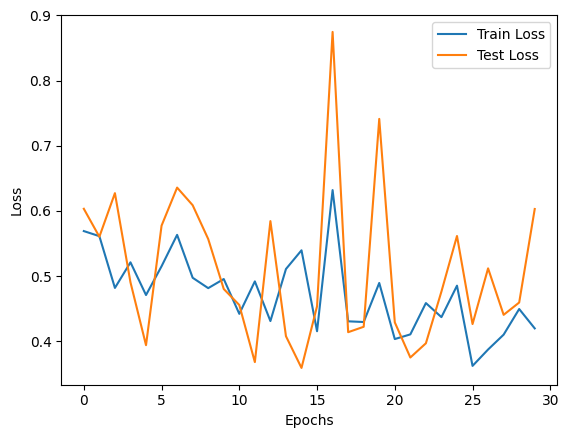

In [ ]:
# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()